In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/cleaned dataset
!pip install torchinfo

/content/drive/MyDrive/cleaned dataset


In [ ]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from helper_functions import set_seeds

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# 1. Get pretrained weights for ViT-Base
pretrained_vit_weights = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
pretrained_vit = torchvision.models.vit_b_16(weights=pretrained_vit_weights).to(device)

# 3. Freeze the base parameters
for parameter in pretrained_vit.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = ['elephant','nonelephant']

set_seeds()
pretrained_vit.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
# pretrained_vit # uncomment for model output

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:03<00:00, 107MB/s] 


In [ ]:
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=pretrained_vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

#### Notice how only the output layer is trainable, where as, all of the rest of the layers are untrainable (frozen).

In [ ]:
# Setup directory paths to train and test images
train_dir = '/content/drive/MyDrive/cleaned dataset/balaenced_custom_data/trainT'
test_dir = '/content/drive/MyDrive/cleaned dataset/balaenced_custom_data/testT'

Remember, if you're going to use a pretrained model, it's generally important to ensure your own custom data is transformed/formatted in the same way the data the original model was trained on.

In [ ]:
# Get automatic transforms from pretrained ViT weights
pretrained_vit_transforms = pretrained_vit_weights.transforms()
print(pretrained_vit_transforms)

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


## And now we've got transforms ready, we can turn our images into DataLoaders using the create_dataloaders()

In [ ]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [ ]:
# Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                     test_dir=test_dir,
                                                                                                     transform=pretrained_vit_transforms,
                                                                                                     batch_size=32) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [ ]:
from going_modular.going_modular import engine

# Create optimizer and loss function
optimizer = torch.optim.Adam(params=pretrained_vit.parameters(),
                             lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

# Train the classifier head of the pretrained ViT feature extractor model
set_seeds()
pretrained_vit_results = engine.train(model=pretrained_vit,
                                      train_dataloader=train_dataloader_pretrained,
                                      test_dataloader=test_dataloader_pretrained,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=100,
                                      device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0531 | train_acc: 0.9884 | test_loss: 0.1760 | test_acc: 0.9375
Epoch: 2 | train_loss: 0.0447 | train_acc: 0.9907 | test_loss: 0.1575 | test_acc: 0.9375
Epoch: 3 | train_loss: 0.0376 | train_acc: 0.9954 | test_loss: 0.1644 | test_acc: 0.9375
Epoch: 4 | train_loss: 0.0344 | train_acc: 0.9954 | test_loss: 0.1583 | test_acc: 0.9297
Epoch: 5 | train_loss: 0.0307 | train_acc: 0.9965 | test_loss: 0.1565 | test_acc: 0.9297
Epoch: 6 | train_loss: 0.0276 | train_acc: 0.9977 | test_loss: 0.1574 | test_acc: 0.9375
Epoch: 7 | train_loss: 0.0262 | train_acc: 0.9965 | test_loss: 0.1530 | test_acc: 0.9375
Epoch: 8 | train_loss: 0.0236 | train_acc: 0.9988 | test_loss: 0.1568 | test_acc: 0.9375
Epoch: 9 | train_loss: 0.0210 | train_acc: 0.9988 | test_loss: 0.1472 | test_acc: 0.9453
Epoch: 10 | train_loss: 0.0258 | train_acc: 0.9988 | test_loss: 0.1494 | test_acc: 0.9453
Epoch: 11 | train_loss: 0.0204 | train_acc: 0.9988 | test_loss: 0.1315 | test_acc: 0.9453
Epoch: 12 | train_l

pretrained ViT performed far better than our custom ViT model trained from scratch (in the same amount of time).


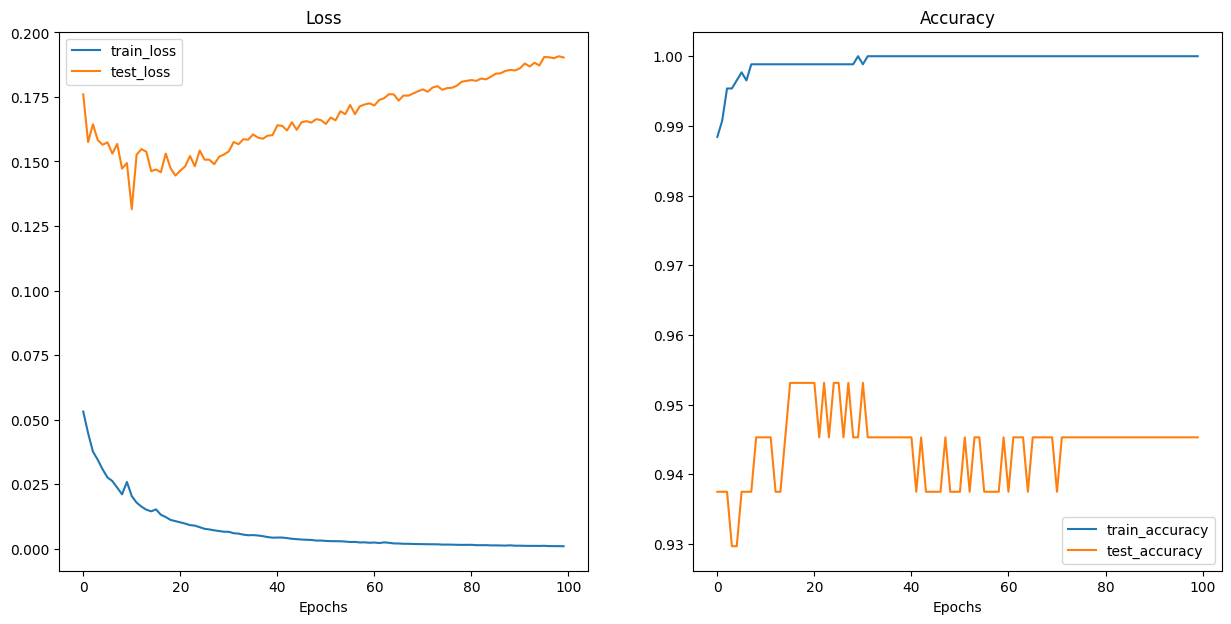

In [ ]:
# Plot the loss curves
from helper_functions import plot_loss_curves

plot_loss_curves(pretrained_vit_results)

## That's the power of transfer learning!

We managed to get outstanding results with the same model architecture, except our custom implementation was trained from scratch (worse performance) and this feature extractor model has the power of pretrained weights from ImageNet behind it.

# Let's make Prediction:

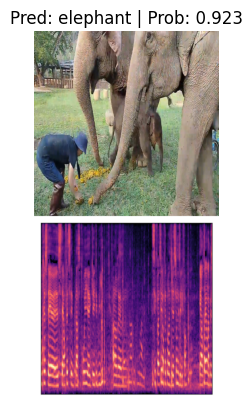

In [ ]:
import requests

# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/drive/MyDrive/cleaned dataset/custom_data/testT/elephant/Pyi Mai is playing the water- EleFlix153.png"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

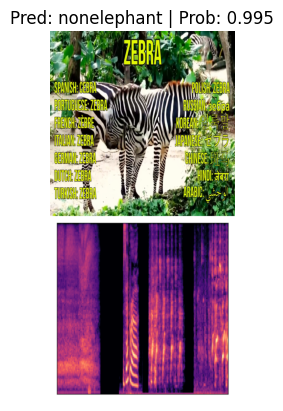

In [ ]:
# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/drive/MyDrive/cleaned dataset/balaenced_custom_data/testT/nonelephant/ANIMAL NAMES AND SOUNDS for Kids Video Compilation - Learn Animal Names for Children & Toddlers283.png"

# Predict on custom image
pred_and_plot_image(model=pretrained_vit,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
torch.save(pretrained_vit.state_dict(), 'epoch_100_trained_model.pth')

In [ ]:
# Create an instance of the ViT Test
from torchvision.models import vision_transformer
Test = vision_transformer.vit_base_patch16_224_in21k()

# Load the Test's weights
Test.load_state_dict(torch.load( 'epoch_100_trained_model.pth'))

# Set the Test to evaluation mode
Test.eval()

print("Test loaded successfully.")

AttributeError: module 'torchvision.models.vision_transformer' has no attribute 'vit_base_patch16_224_in21k'

In [ ]:
w = torchvision.models.ViT_B_16_Weights.DEFAULT

# 2. Setup a ViT model instance with pretrained weights
Test = torchvision.models.vit_b_16(weights=w).to(device)
for parameter in Test.parameters():
    parameter.requires_grad = False

# 4. Change the classifier head
class_names = ['elephant','nonelephant']

set_seeds()
Test.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)
Test.load_state_dict(torch.load( 'epoch_10_trained_model.pth'))


In [ ]:
# Import function to make predictions on images and plot them
from going_modular.going_modular.predictions import pred_and_plot_image

# Setup custom image path
custom_image_path = "/content/drive/MyDrive/cleaned dataset/custom_data/testT/nonelephant/ANIMAL NAMES AND SOUNDS for Kids Video Compilation - Learn Animal Names for Children & Toddlers230.png"

# Predict on custom image
pred_and_plot_image(model=Test,
                    image_path=custom_image_path,
                    class_names=class_names)

In [ ]:
pretrained_vit_results
import pickle

with open('100pepochpretrainedlogs.pkl', 'wb') as f:
    pickle.dump(pretrained_vit_results, f)

with open('100pepochpretrainedlogs.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [ ]:
loaded_dict==pretrained_vit_results

True

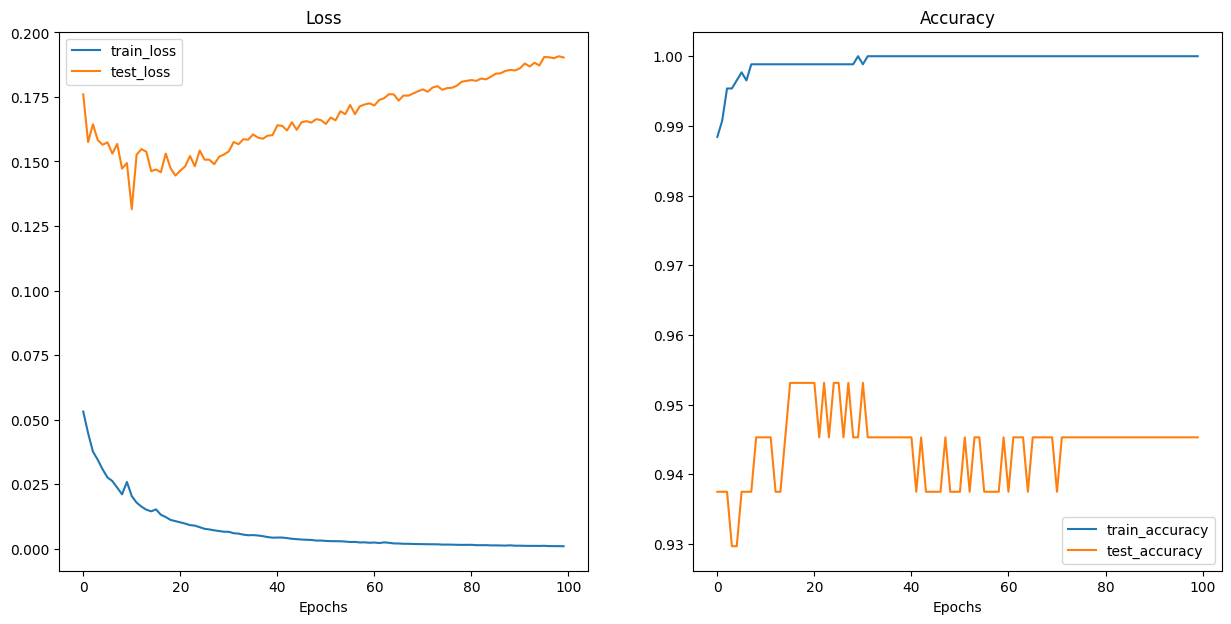

In [ ]:
plot_loss_curves(loaded_dict)